In [110]:
compare = "output/Total_mass" # file name (in the folder "data/model_comparison") of the comparison to be made
consider_models = "all" # list of 4 digit hexa string or "all"
exclude_models = [] # list of 4 digit hexa string or empty list

In [111]:
# Loading models

import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
import pandas as pd
from scipy.signal import savgol_filter
import yaml
from IPython.display import *
import ipywidgets as widgets
from ipywidgets import *
from IPython.display import Image, display

source = f"data/model_comparison/{compare}.yml"

with open(source) as f:
    archives = yaml.safe_load(f)

models = {}

print("Comparing models:")
for model_number, archive in archives.items():

    details = json.load(open(f'{archive}/details.json'))
    model_id = details["model_id"]

    if consider_models != "all"\
            and model_id not in consider_models\
            or model_id in exclude_models:
        continue

    history = np.load(f'{archive}/history.npz', allow_pickle=True)
    content = np.load(f'{archive}/predictions.npz', allow_pickle=True)
    predictions = content["predictions"].item()
    expectations = content["expectations"].item()

    print(f" - {model_number}: {archive}/details.json")
    print(f"      History keys: {', '.join(list(history.keys()))}")
    
    models[model_id] = {
        "archive": archive,
        "details": details,
        "history": history,
        "predictions": predictions,
        "expectations": expectations
    }



Comparing models:
 - 0000: ./archives/2023-04-19_75a8c63/1/details.json
      History keys: loss, Total_mass_MAE, val_loss, val_Total_mass_MAE
 - 0001: ./archives/2023-04-19_75a8c63/2/details.json
      History keys: loss, Total_mass_MAE, val_loss, val_Total_mass_MAE
 - 0002: ./archives/2023-04-19_75a8c63/3/details.json
      History keys: loss, Total_mass_MAE, val_loss, val_Total_mass_MAE


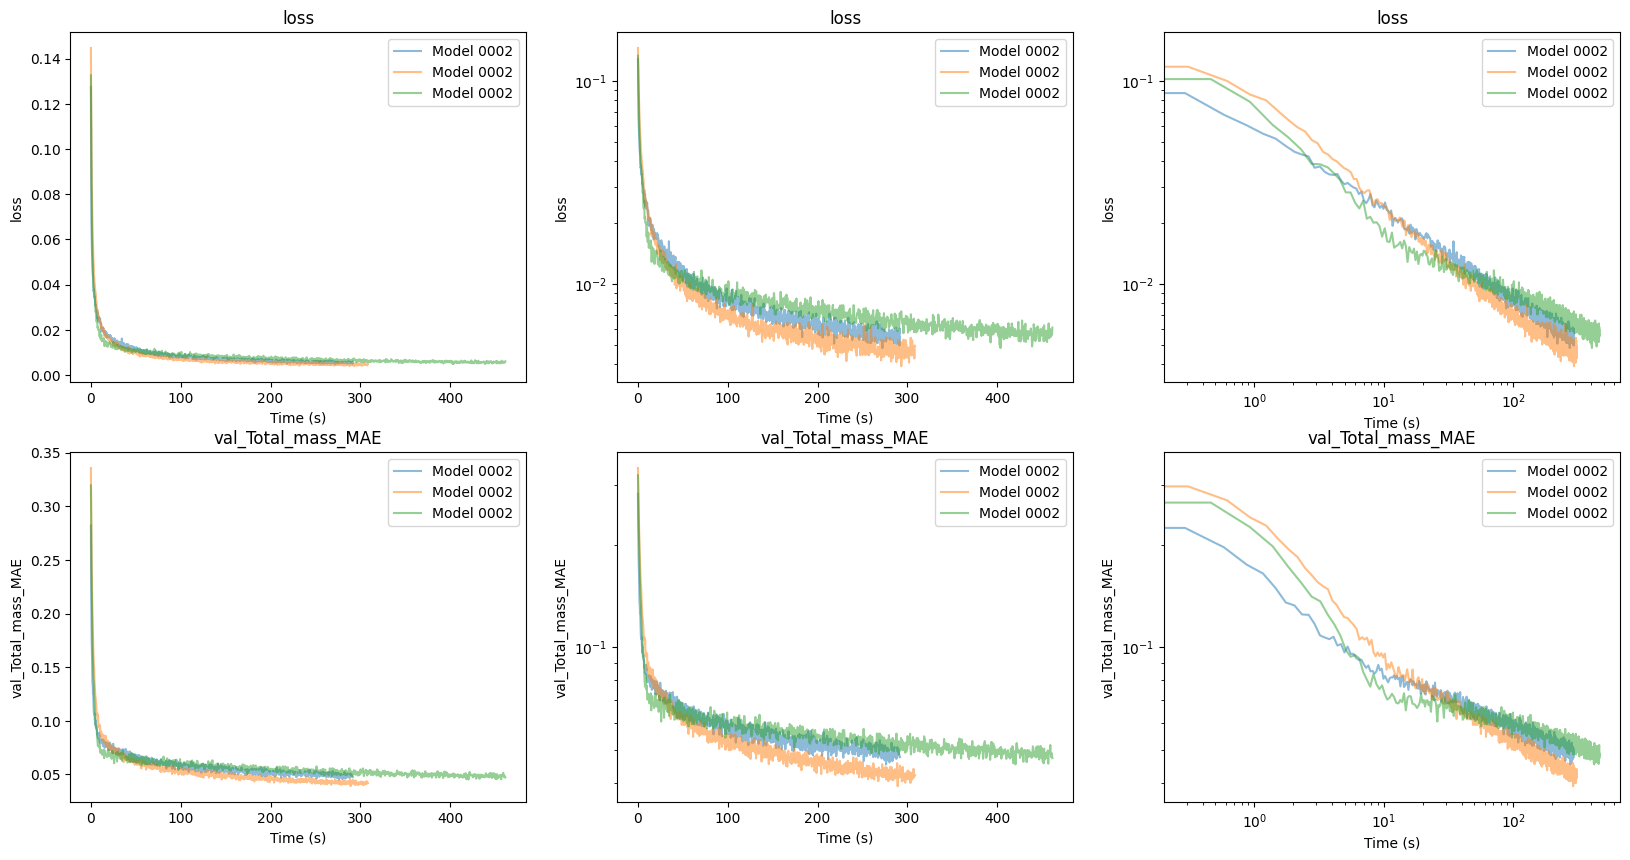

In [112]:
# Plot training evolution

# Looking at how many different val metrics are available
nb_metrics = 1
seen_metrics = ["loss"]
for model_id, model in models.items():
    for key in model["history"].keys():
        if key.startswith("val_") and not key.endswith("loss") and key not in seen_metrics:
            seen_metrics.append(key)
            nb_metrics += 1

fig, axs = plt.subplots(nb_metrics, 3, figsize=(20, 5*nb_metrics))

for model_id, model in models.items():

    history = model["history"]
    time_range = np.linspace(0, model["details"]["training_time"], model["details"]["epochs"], endpoint=True)

    # Printing loss
    for i, key in enumerate(seen_metrics):
        if key in history:
            for ax in axs[i]:
                curve = history[key]
                ax.plot(time_range, curve, alpha=0.5, label=f"Model {model_number}")


for i, row in enumerate(axs):
    for ax in row:
        ax.set_title(seen_metrics[i])
        ax.set_ylabel(seen_metrics[i])
        ax.set_xlabel('Time (s)')
        ax.legend()
    row[1].set_yscale('log')
    row[2].set_xscale('log')
    row[2].set_yscale('log')

plt.show()

SelectMultiple(description='Models', index=(0, 1, 2), options=('0000', '0001', '0002'), value=('0000', '0001',…

Dropdown(description='Output: ', options=('Total_mass',), value='Total_mass')

SelectionRangeSlider(description='Range', index=(0, 299), layout=Layout(width='100%'), options=('2.97e+02', '2…

Button(description='Plot', icon='check', style=ButtonStyle(), tooltip='Click me')

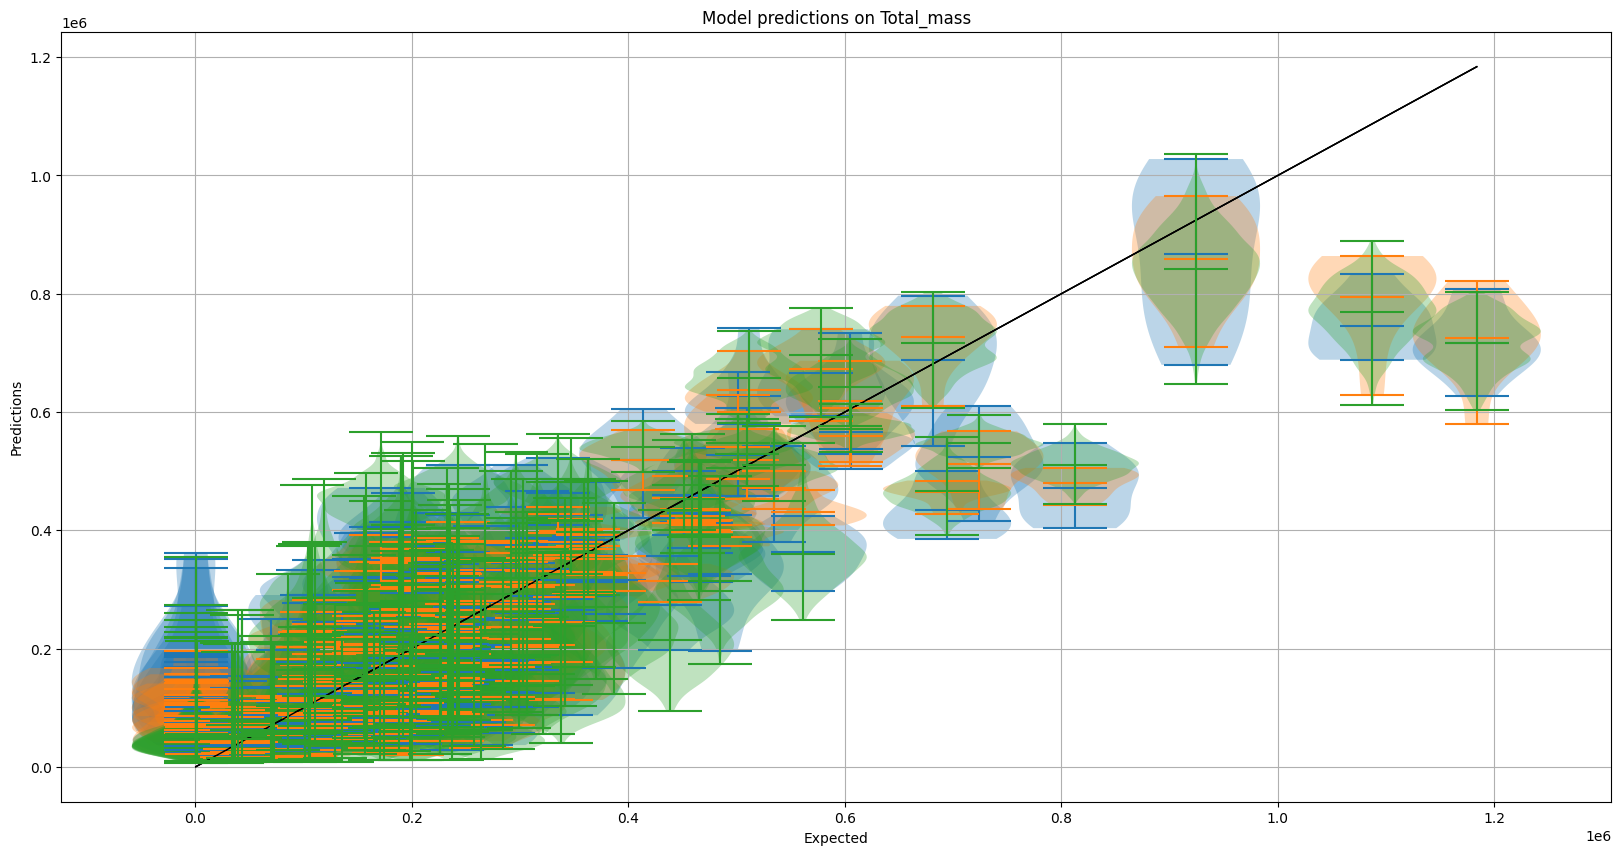

In [115]:
# Prediction distributions

def violin_plot(output, model_list, limits):
    plt.figure(figsize=(20, 10))

    i = 0
    for key in model_list:
        model = models[key]

        predictions = np.array(model["predictions"][output])
        expectations = np.array(model["expectations"][output]).flatten()

        vmin = float(limits[0])
        vmax = float(limits[1])
        eps = float(limits[0]) * 0.02

        mask = ((expectations + eps >= vmin) & (expectations - eps <= vmax)).flatten()

        filtered_predictions = predictions[:,mask]
        filtered_expectations = expectations[mask]

        emin = np.min(filtered_expectations)
        emax = np.max(filtered_expectations)

        plt.plot([emin,emax],[emin,emax], c="black", linewidth=1)

        # for i, prediction in enumerate(filtered_predictions):
        #     filtered_predictions[i] = prediction - filtered_expectations

        

        violin_parts = plt.violinplot(
            dataset=filtered_predictions[:,:],
            positions=filtered_expectations[:], 
            widths=np.max(filtered_expectations)*0.1, showmeans=True, showextrema=True
        )


        # model_id = model["details"]["model_id"]
        
        # color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
        # i+=1

        # first = True
        # for prediction in filtered_predictions:
        #     if first:
        #         plt.scatter(filtered_expectations, prediction, alpha=0.5, s=10, c=color, label=f"Model {model_id}")
        #         first = False
        #     else:
        #         plt.scatter(filtered_expectations, prediction, alpha=0.5, s=10, c=color)
        
        
        
 
    plt.title(f'Model predictions on {output}')
    plt.ylabel('Predictions')
    plt.xlabel('Expected')
    plt.ticklabel_format(axis="both", style='sci', scilimits=(0,0))
    plt.grid()
    # plt.legend()
    plt.show()

# Selecting the metrics to plot -----------------------------------------------

model_list_select = widgets.SelectMultiple(
    options=list(models.keys()),
    value=list(models.keys()),
    description='Models',
    disabled=False
)

sample_model = models[list(models.keys())[0]]
options = list(sample_model["predictions"].keys())
output_widget = Dropdown(options=options, value=options[0], description="Output: ")

def get_possible_expectations():
    possible_expectations = np.array([])
    for model in models.values():
        possible_expectations = np.concatenate((
            possible_expectations,
            model["expectations"][output_widget.value].flatten()
        ))

    possible_expectations = list(map(lambda x: f"{x:.2e}", np.sort(possible_expectations).tolist()))
    return possible_expectations

expectation_slider = widgets.SelectionRangeSlider(
    options=get_possible_expectations(),
    index=(0, len(get_possible_expectations())-1),
    description='Range',
    disabled=False,
    width='100%',
    layout=Layout(width='100%')  
)

plot_button = widgets.Button(
    description='Plot',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

def update_violin_plot(*args):
    clear_output()
    display(model_list_select)
    display(output_widget)
    display(expectation_slider)
    display(plot_button)
    violin_plot(output_widget.value, model_list_select.value, expectation_slider.value)

plot_button.on_click(update_violin_plot)

update_violin_plot()

Dropdown(description='Model ID: ', index=2, options=('0000', '0001', '0002'), value='0002')

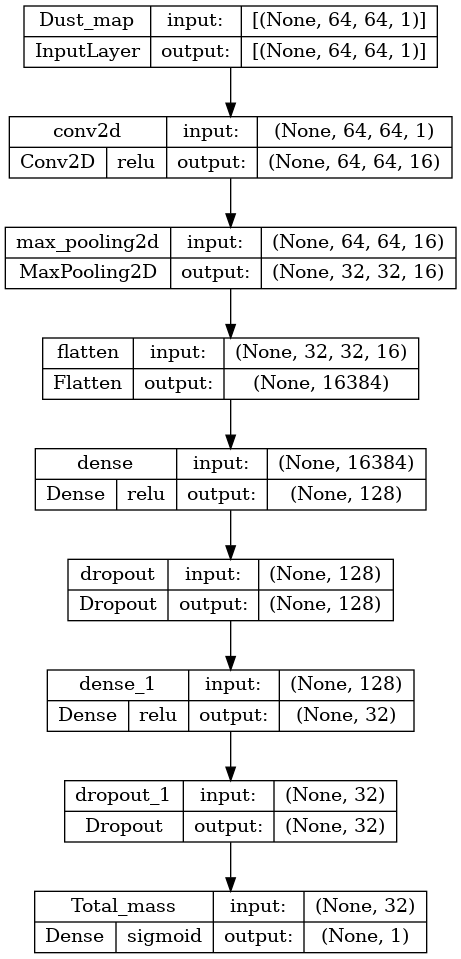

Total params: 2,101,857
Trainable params: 2,101,857
Non-trainable params: 0
_________________________________________________________________

Optimizer: SGD
Loss: mean_squared_error
Metrics:
 - Total_mass_MAE

Epochs: 1000
Batch size: 50

Training time: 7m 41.38s
Score:
 - 3.67e-03
 - 4.45e-02

Validation fraction: 20 %
Test fraction: 10 %

Path: ./archives/2023-04-19_75a8c63/3



In [114]:
# Select model and view details

def print_model_details(id):

    model = models[id]
    archive = model["archive"]
    details = model["details"]

    display(Image(filename=f'{archive}/model.png'))
    print("\n".join(details['summary'][-4:]))

    print("")
    print("Optimizer:", details['optimizer'])
    if isinstance(details['loss'], list):
        print("Loss:\n -", "\n - ".join(details['loss']))
    else:
        print("Loss:", details['loss'])
    print("Metrics:\n -", "\n - ".join(details['metrics']))
    print("")
    print("Epochs:", details['epochs'])
    print("Batch size:", details['batch_size'])
    print("")
    print(f"Training time: {int(details['training_time']//60)}m {details['training_time']%60:.2f}s" )
    print("Score:\n -", "\n - ".join([f"{i:.2e}" for i in details['scores']]))
    print("")
    # print("Dataset size:", details['dataset_size'])
    print("Validation fraction:", int(details['val_frac'] * 100), "%")
    print("Test fraction:", int(details['test_frac'] * 100), "%")
    print("")
    print("Path:", archive)
    print("")
    if "inputs" in details:
        print("Inputs:\n -", "\n - ".join(details['inputs']))
    if "outputs" in details:
        print("Outputs:\n -", "\n - ".join(details['outputs']))


options = [hex(i)[2:] for i in range(len(archives))]
for i, option in enumerate(options):
    options[i] = "0"*(4 - len(option)) + option

selected_model = models[options[0]]

model_widget = Dropdown(options=options, value=options[0], description="Model ID: ")

# Define a function that updates the content of y based on what we select for x
def update_model_widget(*args):
    global selected_model
    clear_output()
    display(model_widget)
    print_model_details(model_widget.value)
    selected_model = models[model_widget.value]

model_widget.observe(update_model_widget)
update_model_widget()